In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import StrMethodFormatter, ScalarFormatter
import seaborn as sns

## Figure 1

In [34]:
all_data = pd.read_csv('all_data_with_intervals.csv')[['Bundesland','week_no','summer_vac','active_lockdown','total_population']]
populations = all_data.groupby('Bundesland')['total_population'].sum().reset_index()
intervals = all_data.drop(columns='total_population').drop_duplicates()

In [35]:
rki_weekly = pd.read_csv('rki_weekly.csv')
rki_weekly['Bundesland'] = rki_weekly.districtId // 1000
state_wise = rki_weekly.groupby(['Bundesland','week_no'])['AnzahlFall'].sum().reset_index().merge(populations)
state_wise['cases_per_cap'] = state_wise.AnzahlFall / state_wise.total_population

In [36]:
plot_data = pd.merge(state_wise, intervals, how='outer')
plot_data.fillna(value=False,inplace=True)
plot_data = plot_data[plot_data.week_no.between(6,39)].copy()#our model was only until week 38, with RF looking ahead 1 week
plot_lockdown = plot_data[plot_data.active_lockdown].copy()
plot_summer = plot_data[plot_data.summer_vac].copy()

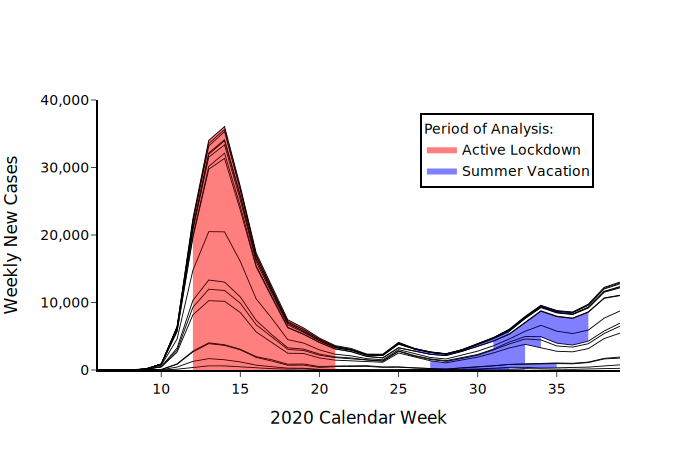

In [37]:
# Y_VAR = 'cases_per_cap'
Y_VAR = 'AnzahlFall'

fig = go.Figure()

value_repo = {}

stackr = {}
for i in np.unique(plot_data.week_no):
    stackr[i] = 0

bl_range = range(1,17) #parametrized here in order to change order etc
    
for bl in bl_range:
    
    df_bl = plot_data[plot_data.Bundesland==bl]

    X_all = []
    Y_all = []
    X_lockdown = []
    Y_lockdown = []
    X_summer = []
    Y_summer = []

    for i, val in df_bl.iterrows():

        x_ = val.week_no
        stackr[x_] += val[Y_VAR]
        y_ = stackr[x_]

        X_all.append(x_)
        Y_all.append(y_)

        if val.active_lockdown:
            X_lockdown.append(x_)
            Y_lockdown.append(y_)

        if val.summer_vac:
            X_summer.append(x_)
            Y_summer.append(y_)
            
        
    value_repo[bl] = {'all':pd.Series(Y_all,index=X_all),
                      'Active Lockdown':pd.Series(Y_lockdown,index=X_lockdown),
                      'Summer Vacation':pd.Series(Y_summer,index=X_summer)}

    
def add_areas(bl, timeslice, color):
    
    suppl_line_attrs = {'mode':'lines','line_width':0,'hoverinfo':'none'}
    
    not_first = bl != bl_range[0]
    
    if not_first:#this creates invisible lines for the areas to fill down towards, otherwise area borders are not vertical
        last_y = value_repo[bl-1]['all']
        last_y = last_y[last_y.index.isin(vals[timeslice].index)]
        
        fig.add_trace(go.Scatter(x=vals[timeslice].index,
                                 y=last_y,
                                 fill=None,
                                 showlegend=False,
                                 **suppl_line_attrs))
    
    fig.add_trace(go.Scatter(x=vals[timeslice].index,
                             y=vals[timeslice],
                             fill='tonexty' if not_first else 'tozeroy',
                             #explicit tozeroy, because we add traces per BL multiple times,
                             name=None if not_first else timeslice,
                             showlegend= not not_first,
                             line_color=color,
                             **suppl_line_attrs))
    
for bl in bl_range: #not iter directly over dict to potentially change order
    vals = value_repo[bl]
    #now summer
    add_areas(bl, 'Summer Vacation', 'blue')
    
    #now the lockdown
    add_areas(bl, 'Active Lockdown', 'red')
    
    
    #now rest
    fig.add_trace(go.Scatter(x=vals['all'].index,
                             y=vals['all'],
                             fill=None,
                             showlegend=False,
                             line_color='black',
                             line_width=.9,
                             mode='lines',
                             hoverinfo='none'))

axis_attrs = dict(showgrid=False,
        showline=True, linewidth=2, linecolor='black',
        ticks='outside'
)    

fig.update_layout(
    title=dict(
        #text="Weekly New Covid-19 Cases in Germany by Province",
        xanchor='center',
        x=.5),
    xaxis_title="2020 Calendar Week",
    yaxis_title="Weekly New Cases",
    legend_title="Period of Analysis:",
    legend=dict(
        #orientation="h",
        yanchor="top",
        y=.95,
        xanchor="right",
        x=.95,
        bordercolor="Black",
        borderwidth=2
    ),
    font=dict(
        size=14,
        color="black"
    ),
    xaxis = dict(
        **axis_attrs
        ),
    yaxis = dict(
        **axis_attrs,
        exponentformat='none',
        range=[0,40000],
        dtick=10**4
    ),
    plot_bgcolor='white'
)
fig.write_image('paper_figures/Figure1.png',engine='kaleido');fig.show(renderer='svg')


# Kernel of Peers  

In [38]:
EXAMPLE_DISTRICT = 8336

In [39]:
struct = pd.read_csv('processed_static_data.csv').set_index('districtId')

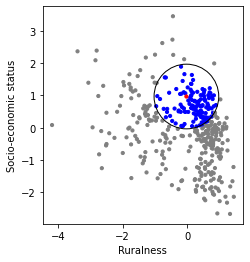

In [40]:
CIRCLE_RADIUS = 1

district_name = struct.district_name.at[EXAMPLE_DISTRICT]
center_rur = struct.rur_z.at[EXAMPLE_DISTRICT]
center_ses = struct.ses_z.at[EXAMPLE_DISTRICT]

struct['distance'] = np.sqrt((struct.rur_z - center_rur)**2 + (struct.ses_z - center_ses)**2)
struct['peer_bool'] = struct.distance <= 1
struct['color'] = struct.peer_bool.map({True:'blue',
                                       False:'grey'})
struct.at[EXAMPLE_DISTRICT,'color'] = 'red'
struct['plot_order'] = struct.index == EXAMPLE_DISTRICT
struct.sort_values('plot_order', inplace=True)

fig, ax = plt.subplots()

ax.scatter(struct.rur_z,struct.ses_z,s=10,c=struct.color)
ax.add_artist(plt.Circle((center_rur,center_ses),CIRCLE_RADIUS,fill=False))

ax.set_aspect(1)
# ax.set_title('Vergleichslandkreise (blau) für '+district_name+' (rot)')
ax.set_xlabel('Ruralness')
ax.set_ylabel('Socio-economic status')

fig.savefig('paper_figures/kernel_of_peers.svg')


## Plot PD and other special districts 

In [5]:
deviance = pd.read_csv('deviance_df.csv')

In [6]:
summer_pds = deviance.districtId[deviance.is_summer_pd]
lockdown_pds = deviance.districtId[deviance.is_lockdown_pd]

In [7]:
all_data = pd.read_csv('all_data_with_intervals.csv')
# all_data.columns

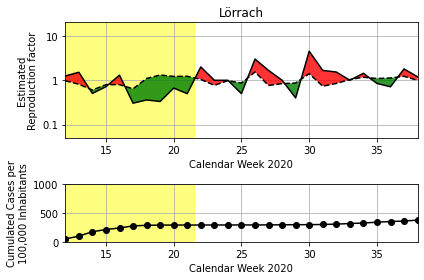

In [8]:
def plot_district(districtId, interval, title=None, save=True):
    district_data = all_data[all_data.districtId == districtId].copy()
    district_name = district_data.district_name.iat[0] if title is None else title
    date_range = district_data.week_no.agg(['min','max'])
    marked_time = district_data.loc[district_data[interval],'week_no'].agg(['min','max'])
    marking_attrs = {'xmin':marked_time[0]-.5,
                    'xmax':marked_time[1]+.5,
                    'color':'yellow',
                    'alpha':.5,
                    'zorder':0}
    
    x = district_data.week_no
    r0_obs =  district_data.target
    r0_pred = district_data.target_predicted
    cases = district_data.AnzahlFall_cumul_per_cap * (10**5) #cases per 100k
    
    
    
    fig, (ax_r, ax_c) = plt.subplots(2, gridspec_kw={'height_ratios':[2,1]})    #axis R0, axis case numbers

    ax_r.grid(True, zorder=1)    
    ax_r.axvspan(**marking_attrs)
    
    r_ticks = [.1,1,10]
    
    ax_r.yaxis.set_ticks([np.log(i) for i in r_ticks])
    ax_r.yaxis.set_ticklabels(r_ticks)
    ax_r.set_ylim(-3,3)
    ax_r.set_xlim(*date_range)
#     ax_r.set_title(district_name + '\n --- - Vorhersage; ___ - Beobachtet')
    ax_r.set_xlabel('Calendar Week 2020')
    ax_r.set_ylabel('Estimated\nReproduction factor')
    
    title_or_name = title if title else district_name 
    
    ax_r.set_title(title_or_name)
#     ax_r.set_xlabel('Week')
#     ax_r.set_ylabel('Estimated\nReproduction Factor')

    
    lines_attrs = {'color':'black',
                  'zorder':3}
    line_obs,=ax_r.plot(x,r0_obs,**lines_attrs)
    line_pred,=ax_r.plot(x,r0_pred, linestyle='--', **lines_attrs)    
#     ax_r.legend((line_obs,line_pred),('Observed','Predicted'))
    filler_attrs = {'x':x,
                   'y1':r0_obs,
                   'y2':r0_pred,
                   'interpolate':True,
                   'zorder':2,
                   'alpha':.8}
    ax_r.fill_between(where=r0_obs <= r0_pred, facecolor='green', **filler_attrs)
    ax_r.fill_between(where=r0_obs >= r0_pred, facecolor='red', **filler_attrs)
    

    
    color_c = 'k'
    ax_c.plot(x, cases, color = color_c, marker='o')
    
    ax_c.axvspan(**marking_attrs)
    ax_c.set_xlabel('Calendar Week 2020')
    ax_c.set_ylabel('Cumulated Cases per\n100,000 Inhabitants', color = color_c)
    ax_c.tick_params(axis='y', labelcolor = color_c)
    ax_c.grid(True)
    ax_c.set_ylim(0, 1000)
    ax_c.set_xlim(*date_range)
    
    fig.tight_layout()
    
    if save:
        fig.savefig('paper_figures/'+title_or_name+'.svg')
        
    plt.show()

plot_district(8336,'active_lockdown', save=False)

For validity checking, we also include the worst and median performers for each deviance:

In [45]:
def get_relevant_districts(var, n_best=3):
    sort = deviance.sort_values(var, ascending=False)
    n = sort.shape[0]
    
    top_x = []
    for i in range(n_best):
        top_x.append(sort.districtId.iat[i])
    
    median = sort.districtId.iat[n//2]    
    worst = sort.districtId.iat[n-1]
    
    return top_x, median, worst

In [46]:
ld_best, ld_median, ld_worst = get_relevant_districts('lockdown_z')
su_best, su_median, su_worst = get_relevant_districts('summer_z')

Lockdown Top 3:

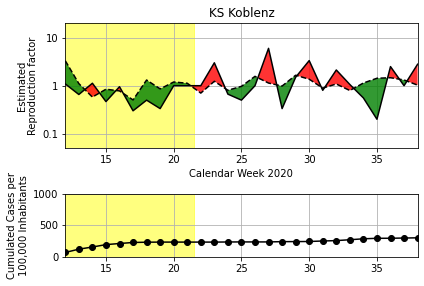

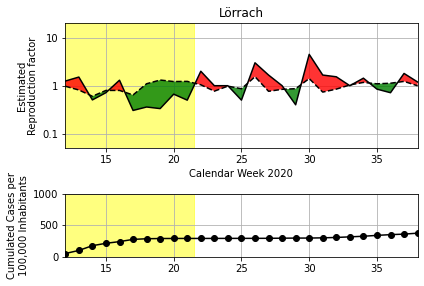

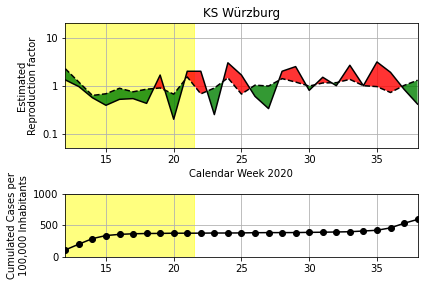

In [47]:
for d in ld_best:
    plot_district(d,'active_lockdown')

Summer Top 3:

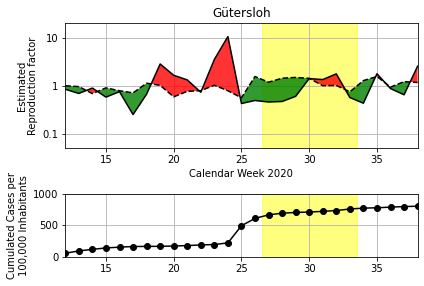

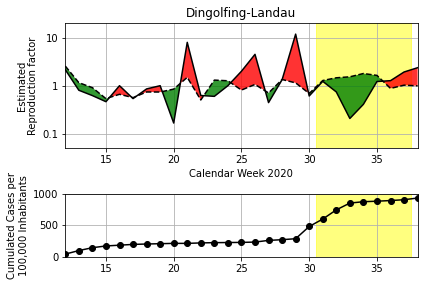

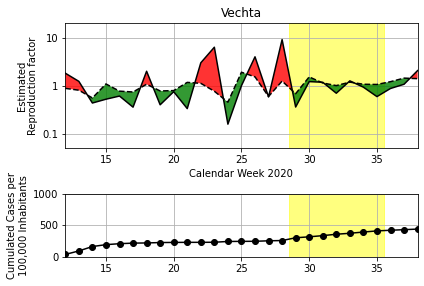

In [48]:
for d in su_best:
    plot_district(d,'summer_vac')

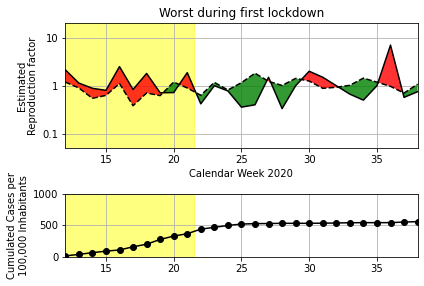

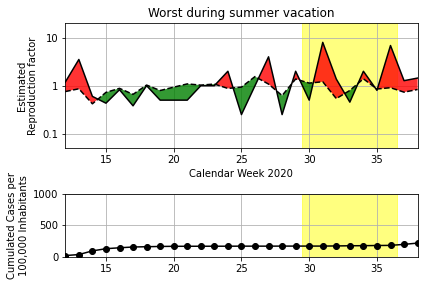

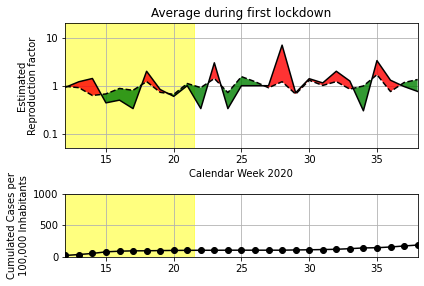

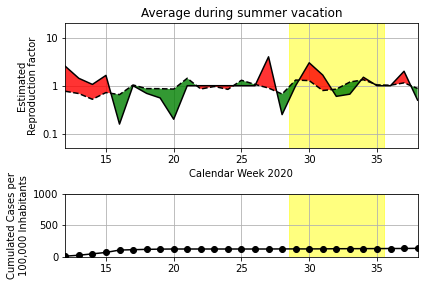

In [49]:
plot_district(ld_worst, 'active_lockdown', 'Worst during first lockdown')
plot_district(su_worst, 'summer_vac', 'Worst during summer vacation')
plot_district(ld_median, 'active_lockdown', 'Average during first lockdown')
plot_district(su_median, 'summer_vac', 'Average during summer vacation')

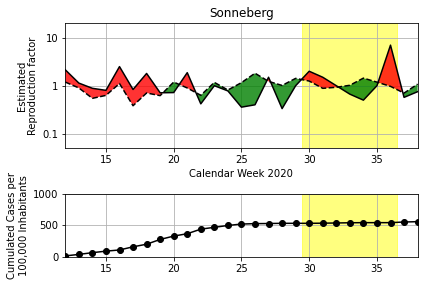

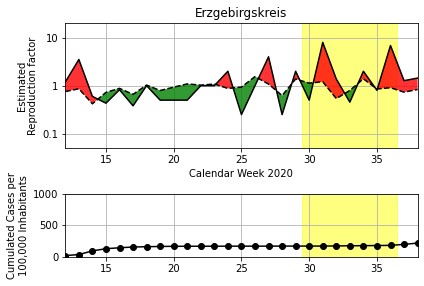

In [52]:
# plot_district(ld_worst,'summer_vac')
# plot_district(su_worst,'summer_vac')

## Analysis Flowchart 

In [ ]:
# all_data = pd.read_csv('all_data_with_intervals.csv')

In [ ]:
# district_data = all_data[all_data.districtId == EXAMPLE_DISTRICT].copy()
# district_name = district_data.district_name.iat[0]
# ld_full = list(district_data.active_lockdown)
# ld_trunc = [ld_full[i-1] and ld_full[i] and ld_full[i+1] for i in range(len(ld_full))]
# sv_full = list(district_data.summer_vac)
# sv_trunc = [sv_full[i-1] and sv_full[i] and sv_full[i+1] for i in range(len(sv_full))]

# lockdown_weeks = district_data.loc[district_data.active_lockdown,'week_no'].agg(['min','max'])
# summer_weeks = district_data.loc[district_data.summer_vac,'week_no'].agg(['min','max'])
    
# x= district_data.week_no
# y1 = district_data.target
# y2 = district_data.target_predicted

# fig, ax = plt.subplots()    


# ax.plot(x, y1, color = 'black')
# ax.set_ylim((-3,3))
# ax.set_title(district_name)
# ax.set_xlabel('Calendar week 2020')
# ax.set_ylabel('Log-R0')
# fig.savefig('paper_figures/flowchart/Weekly_R0.svg')

# ax.plot(x, y2, color = 'black', ls='--')
# ax.fill_between(x, y1, y2, where=y1 < y2, alpha=.5, facecolor='green', interpolate=True)
# ax.fill_between(x, y1, y2, where=y1 > y2, alpha=.5, facecolor='red', interpolate=True)

# fig.savefig('paper_figures/flowchart/Weekly_R0_and_pred.svg')

# ax.fill_between(x, y1, y2, where=(y1 < y2)&np.logical_or(ld_full, sv_full), alpha=.8, facecolor='green', interpolate=False)
# ax.fill_between(x, y1, y2, where=(y1 > y2)&np.logical_or(ld_full, sv_full), alpha=.8, facecolor='red', interpolate=False)
# #This causes vertical ends of the highlighted areas

# ax.fill_between(x, y1, y2, where=(y1 < y2)&np.logical_or(ld_trunc, sv_trunc), alpha=1, facecolor='green', interpolate=True)
# ax.fill_between(x, y1, y2, where=(y1 > y2)&np.logical_or(ld_trunc, sv_trunc), alpha=1, facecolor='red', interpolate=True)
# #This fills the gaps where y1 and y2 intersect, and thus the above filling did not occur

# fig.savefig('paper_figures/flowchart/Deviance_timeframes_marked.svg')



## Incidences 

In [13]:
# VAR = 'AnzahlFall_cumul_per_cap'

# deviance = pd.read_csv('deviance_df.csv')

# summer_pds = deviance.districtId[deviance.is_summer_pd]
# lockdown_pds = deviance.districtId[deviance.is_lockdown_pd]

# rki_weekly = pd.read_csv('rki_weekly.csv')

# incidences = pd.DataFrame({'German_average':rki_weekly.groupby('week_no')[VAR].mean(),
#                           'German_min':rki_weekly.groupby('week_no')[VAR].min(),
#                           'German_max':rki_weekly.groupby('week_no')[VAR].max(),})

# intervals = pd.read_csv('all_data_with_intervals.csv')

# def add_PDs(id_list,interval):
#     for d in id_list:
#         weeks_to_include = intervals.week_no[(intervals.districtId==d) & (intervals[interval])]
#         case_data = rki_weekly[(rki_weekly.districtId==d)]
#         incidences[str(d)+'all'] = case_data.set_index('week_no')[VAR]
#         pd_weeks = case_data[case_data.week_no.isin(weeks_to_include)]
#         incidences[str(d)+'cut'] = pd_weeks.set_index('week_no')[VAR]

# add_PDs(summer_pds,'summer_vac')

# add_PDs(lockdown_pds,'active_lockdown')

# cols = incidences.columns
# colors = ['black','grey','grey'] + ['salmon','darkred'] * 3 + ['lightblue', 'darkblue'] * 3
# x = incidences.index

# fig, ax = plt.subplots()

# for i in range(1,len(cols)):
    
#     ax.plot(x,incidences[cols[i]],c=colors[i])
# ax.plot(x,incidences[cols[0]],c=colors[0])
# ax.set_title('Blue: Lockdown PDs (dark part = lockdown)\nRed: Summer PDs (dark part = vacation)\nBlack: German average, Grey: German minimum and maximum')
# ax.set_xlabel('Calendar Week 2020')
# ax.set_ylabel('Cumulated Cases per capita')

# # fig.savefig('paper_figures/___.svg')
